In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

# General libraries
%matplotlib inline
from sklearn.utils import shuffle
import fnmatch
import random
import visualkeras

#Model
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, ZeroPadding2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

2023-04-01 10:55:38.479202: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 10:55:39.002873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv(os.path.join('./csv/', 'train_labels.csv'))
df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [3]:
print("Train Size: {}".format(len(os.listdir('./train/'))))
print("Test Size: {}".format(len(os.listdir('./test/')))) 

Train Size: 220026
Test Size: 57458


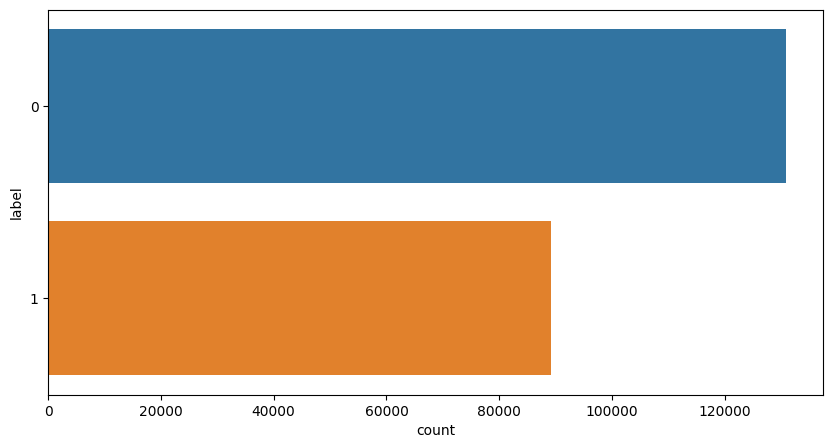

In [4]:
label_count =df.label.value_counts()
# Plot 1
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(y = 'label', data= df)
plt.show()

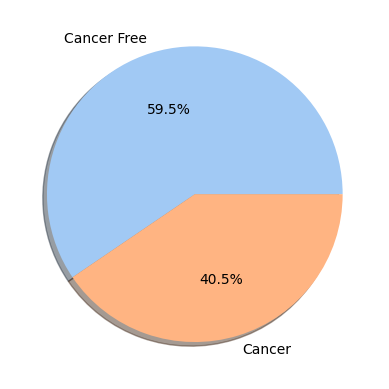

In [5]:
# plot 2
classes = ['Cancer Free', 'Cancer']
palette = sns.color_palette('pastel')
plt.pie(label_count, labels=classes, colors=palette, autopct='%.1f%%', shadow = True)
plt.show()
# pie(x) -- x must be 1D array

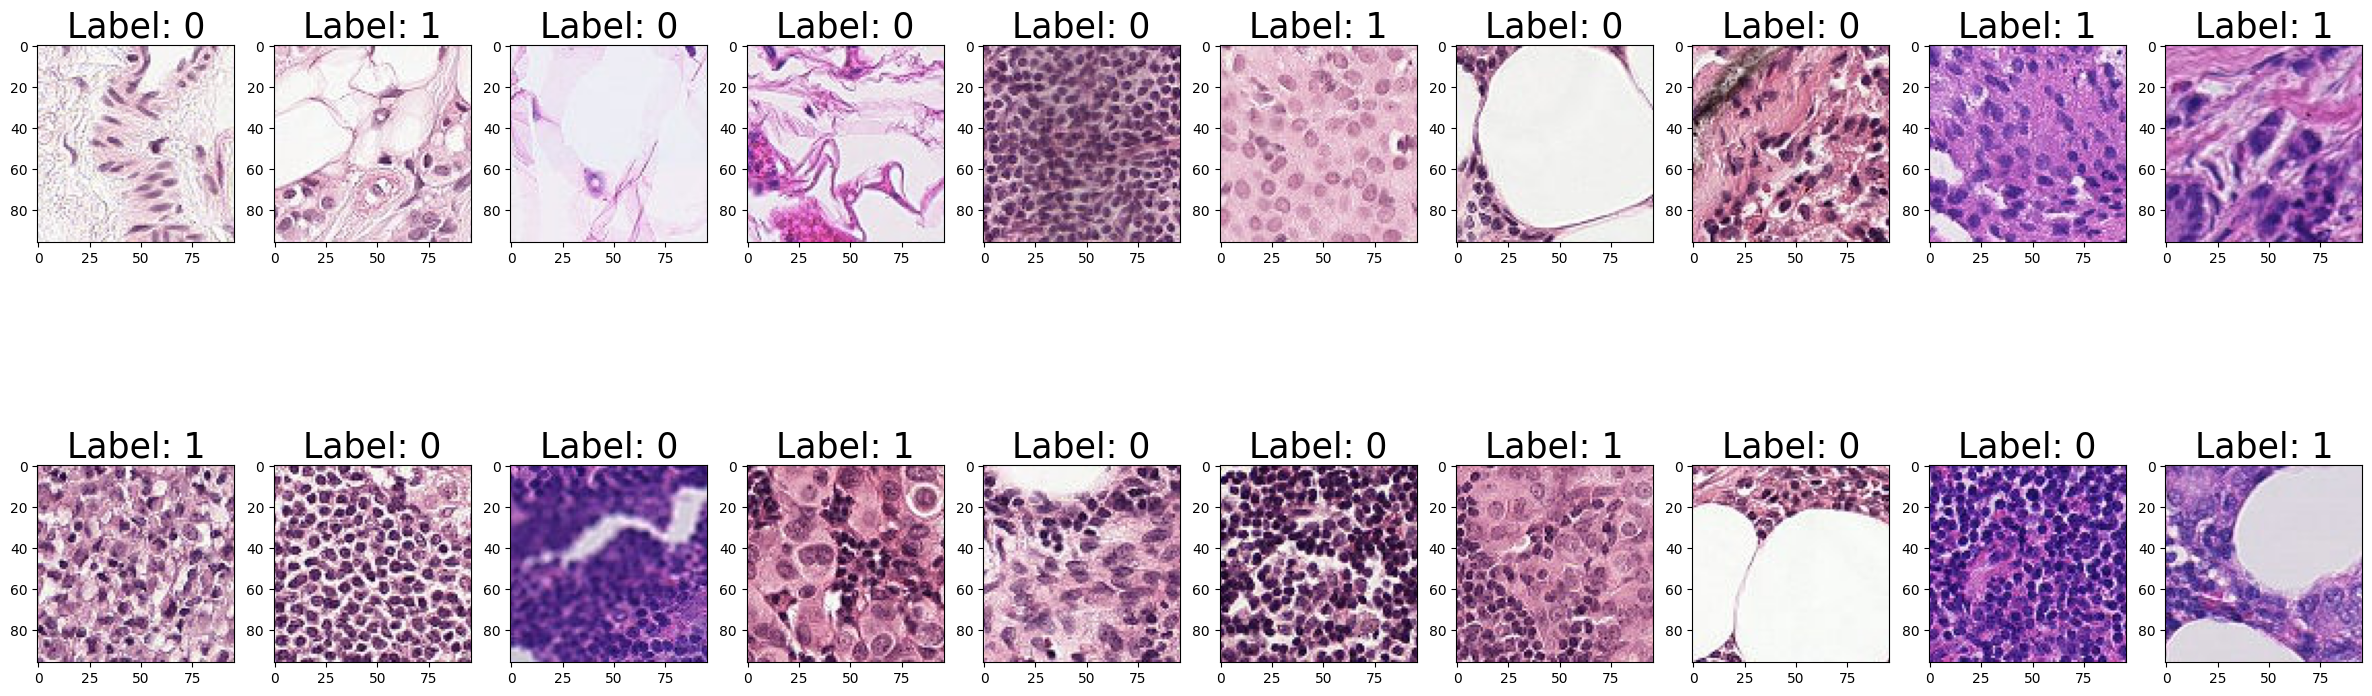

In [6]:
fig = plt.figure(figsize =(30, 10))
train_images = os.listdir('./train/')
for idx, img in enumerate(np.random.choice(train_images, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1)
    im = Image.open('./train/' + img)
    plt.imshow(im)
    label = df.loc[df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%label, fontsize = 25)

In [7]:
train_path = './train/'
test_path = './test/'
sample_submission = pd.read_csv('./sample/sample_submission.csv')

test_data_new = pd.DataFrame({'id':os.listdir(test_path)})

In [8]:
print("---------- train data ---------------")
print(df.head())
df['id'] = df['id'] + '.tif'
df['label'] = df['label'].astype(str)
#main_df['id'] = df['id'].astype(str)
print("---------- train data (after appending file extension)---------------")
print(df.head())
print("---------- test data ---------------")

print(df.shape)

print(df.info())

print(df.label.unique())

---------- train data ---------------
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
---------- train data (after appending file extension)---------------
                                             id label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0
---------- test data ---------------
(220025, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null 

In [9]:
batchSize = 64
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=batchSize,
    seed=985723,
    class_mode="binary",
    target_size=(64,64))  

valid_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=batchSize,
    seed=985723,
    class_mode="binary",
    target_size=(64,64))  

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (64, 62, 62, 16)          448       
                                                                 
 conv2d_1 (Conv2D)           (64, 60, 60, 16)          2320      
                                                                 
 max_pooling2d (MaxPooling2D  (64, 30, 30, 16)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (64, 28, 28, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 14, 14, 32)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (64, 12, 12, 32)          9

2023-04-01 03:57:58.137151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-01 03:57:58.137387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-01 03:57:58.152492: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

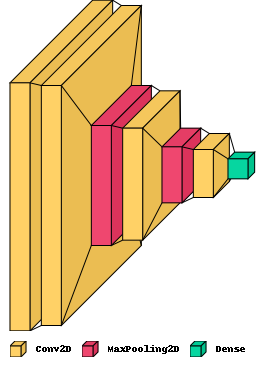

In [10]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
# with tpu_strategy.scope():    
#create model
model1 = Sequential()

model1.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model1.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
#model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))

#build model by input size
model1.build(input_shape=(batchSize, 64, 64, 3))

#compile
adam_optimizer = Adam(learning_rate=0.0001)
model1.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam_optimizer)

#Summary of model
model1.summary()

visualkeras.layered_view(model1, type_ignore=[ZeroPadding2D, Flatten], legend=True)

In [11]:
EPOCHS = 15
# train the model
history_model1 = model1.fit(train_generator,epochs = EPOCHS,validation_data = valid_generator)

Epoch 1/15


2023-04-01 03:57:59.288946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-01 03:58:00.621400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-01 03:58:01.192352: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fa9a401c480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-01 03:58:01.192390: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-04-01 03:58:01.192396: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): Quadro P6000, Compute Capability 6.1
2023-04-01 03:58:01.196771: I tensorflow/compiler/mlir/tensor

2749/2751 [============================>.] - ETA: 0s - loss: 0.4763 - accuracy: 0.7758

2023-04-01 03:59:10.365389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2751/2751 [==============================] - 88s 31ms/step - loss: 0.4762 - accuracy: 0.7758 - val_loss: 0.4505 - val_accuracy: 0.7906
Epoch 2/15
2751/2751 [==============================] - 85s 31ms/step - loss: 0.4325 - accuracy: 0.8035 - val_loss: 0.4135 - val_accuracy: 0.8139
Epoch 3/15
2751/2751 [==============================] - 84s 31ms/step - loss: 0.4081 - accuracy: 0.8173 - val_loss: 0.4021 - val_accuracy: 0.8212
Epoch 4/15
2751/2751 [==============================] - 84s 31ms/step - loss: 0.3914 - accuracy: 0.8266 - val_loss: 0.3779 - val_accuracy: 0.8345
Epoch 5/15
2751/2751 [==============================] - 84s 31ms/step - loss: 0.3792 - accuracy: 0.8332 - val_loss: 0.3663 - val_accuracy: 0.8403
Epoch 6/15
2751/2751 [==============================] - 85s 31ms/step - loss: 0.3681 - accuracy: 0.8400 - val_loss: 0.3572 - val_accuracy: 0.8462
Epoch 7/15
2751/2751 [==============================] - 84s 31ms/step - loss: 0.3616 - accuracy: 0.8436 - val_loss: 0.3573 - val_accura

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


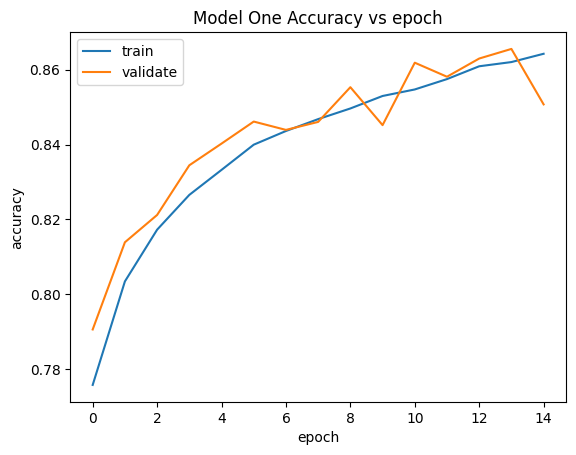

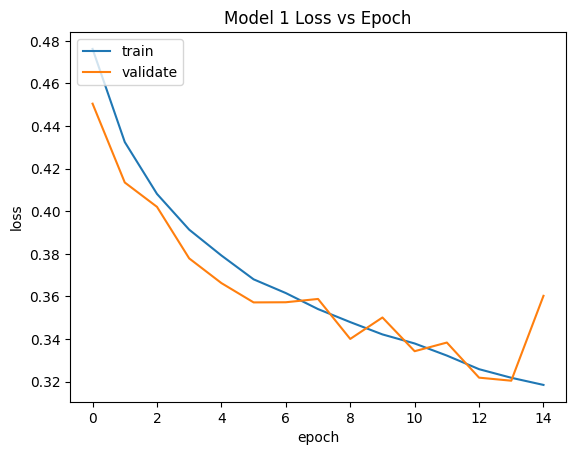

In [14]:
print(history_model1.history.keys())

# plot model accuracy per epoch 
plt.plot(history_model1.history['accuracy'])
plt.plot(history_model1.history['val_accuracy'])
plt.title('Model One Accuracy vs epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history_model1.history['loss'])
plt.plot(history_model1.history['val_loss'])
plt.title('Model 1 Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();


In [15]:
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_data_new,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [26]:
predictions = model1.predict(test_generator, verbose=1)

  124/57458 [..............................] - ETA: 1:10

2023-04-01 04:27:07.681694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57458/57458 [==============================] - 69s 1ms/step


In [30]:
predictions_saved = predictions

In [32]:
predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_data_new['id'].apply(lambda x: x.split('.')[0])
threshold = 0.5
binary_predictions = np.where(predictions < threshold, 0, 1)
submission_df['label'] = binary_predictions.tolist()
submission_df.head()

,id,label
0,53c4ded2d590681ca13d744c486c71d322a16057,0
1,8c30c2be587fff64599c6b6139c86dd24995c02c,0
2,50ddfc340d46b4e7056221450d35df1d77903e3f,1
3,b3c6fc1f0976632729f24647732a59c3e00b218a,0
4,a176eb24bbfc11549b78cd5dd49c0b852db0590c,1


0    34605
1    22853
Name: label, dtype: int64


([<matplotlib.patches.Wedge at 0x7faa340e2a00>,
 [Text(-0.3473575328639432, 1.04371583506368, '0-Non-cancerous'),
  Text(0.34735753286394333, -1.04371583506368, '1-Cancerous')],
 [Text(-0.18946774519851445, 0.5692995463983709, '60.23%'),
  Text(0.18946774519851453, -0.5692995463983709, '39.77%')])

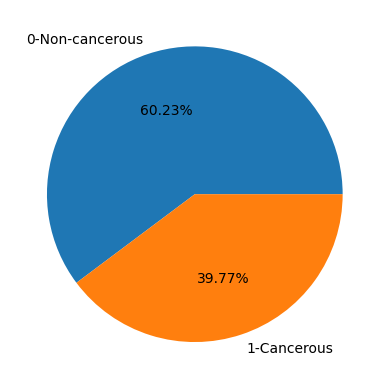

In [33]:
unique_counts = submission_df['label'].value_counts()
print(unique_counts)

plt.pie(unique_counts.tolist(), 
        labels = ['0-Non-cancerous','1-Cancerous'],
        autopct='%1.2f%%'
       )

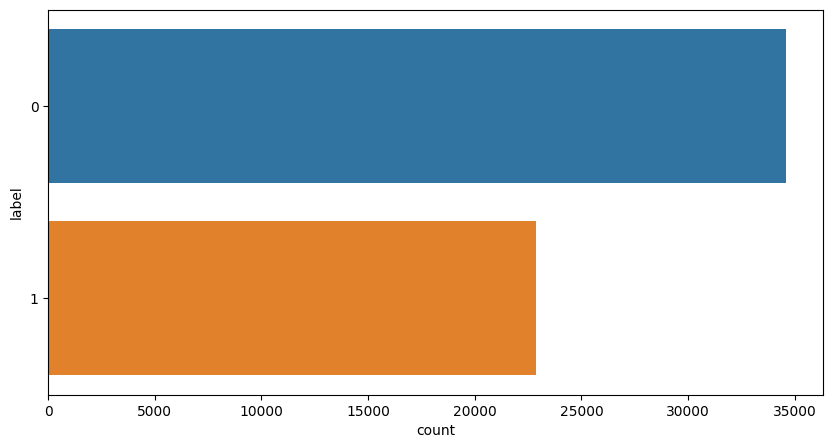

In [36]:
label_count =submission_df.label.value_counts()
# Plot 1
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(y = 'label', data= submission_df)
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (64, 62, 62, 16)          448       
                                                                 
 conv2d_1 (Conv2D)           (64, 60, 60, 16)          2320      
                                                                 
 max_pooling2d (MaxPooling2D  (64, 30, 30, 16)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (64, 30, 30, 16)          0         
                                                                 
 batch_normalization (BatchN  (64, 30, 30, 16)         64        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (64, 28, 28, 32)          4

2023-04-01 10:56:28.850047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-01 10:56:28.850284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-01 10:56:28.865245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

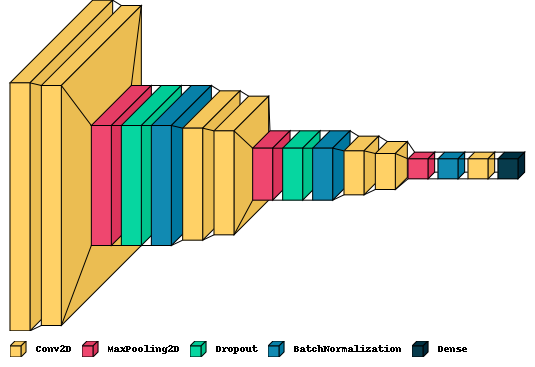

In [10]:
model2_auc = tf.keras.metrics.AUC()
    
# with tpu_strategy.scope():       
#create model
model2 = Sequential()

model2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.1))

model2.add(BatchNormalization())
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.1))

model2.add(BatchNormalization())
model2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(BatchNormalization())
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

#build model by input size
model2.build(input_shape=(batchSize, 64, 64, 3))

#compile
adam_optimizer = Adam(learning_rate=0.0001)
model2.compile(loss='binary_crossentropy', metrics=['accuracy', model2_auc], optimizer=adam_optimizer)

# Summary of the 2nd model
model2.summary()

visualkeras.layered_view(model2, type_ignore=[ZeroPadding2D, Flatten], legend=True)

In [11]:
EPOCHS = 15

# train model
history_model2 = model2.fit(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

Epoch 1/15


2023-04-01 10:56:39.342492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-01 10:56:40.456193: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-01 10:56:41.174593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-01 10:56:41.859073: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x3a183660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-01 10:56:41.859096: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device

2751/2751 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.7916 - auc: 0.8614

2023-04-01 10:57:53.159659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2751/2751 [==============================] - 90s 31ms/step - loss: 0.4524 - accuracy: 0.7916 - auc: 0.8614 - val_loss: 0.4029 - val_accuracy: 0.8281 - val_auc: 0.8908
Epoch 2/15
2751/2751 [==============================] - 85s 31ms/step - loss: 0.3803 - accuracy: 0.8325 - auc: 0.9048 - val_loss: 0.3636 - val_accuracy: 0.8425 - val_auc: 0.9154
Epoch 3/15
2751/2751 [==============================] - 85s 31ms/step - loss: 0.3509 - accuracy: 0.8485 - auc: 0.9196 - val_loss: 0.3487 - val_accuracy: 0.8512 - val_auc: 0.9265
Epoch 4/15
2751/2751 [==============================] - 85s 31ms/step - loss: 0.3275 - accuracy: 0.8597 - auc: 0.9299 - val_loss: 0.3414 - val_accuracy: 0.8544 - val_auc: 0.9269
Epoch 5/15
2751/2751 [==============================] - 85s 31ms/step - loss: 0.3086 - accuracy: 0.8702 - auc: 0.9379 - val_loss: 0.3178 - val_accuracy: 0.8664 - val_auc: 0.9425
Epoch 6/15
2751/2751 [==============================] - 85s 31ms/step - loss: 0.2944 - accuracy: 0.8771 - auc: 0.9436 - v

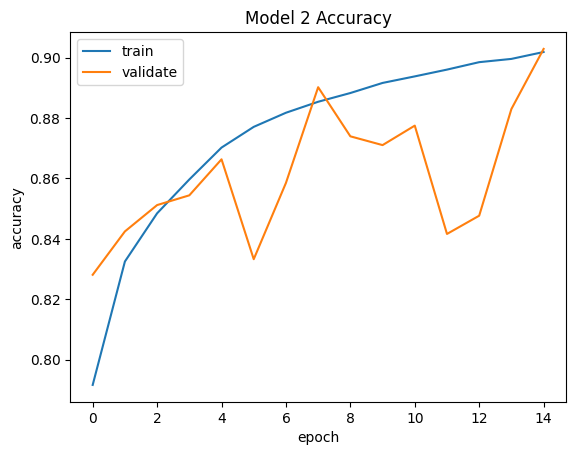

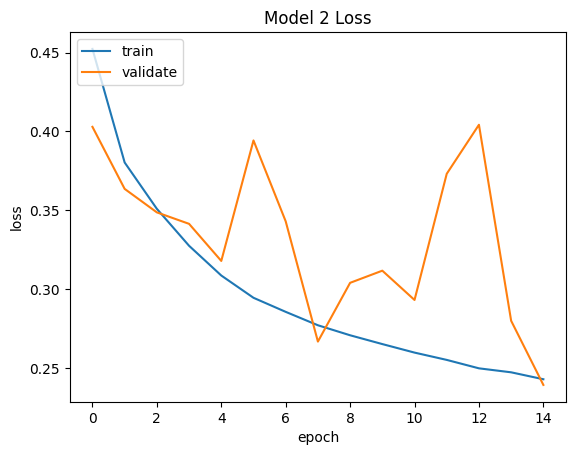

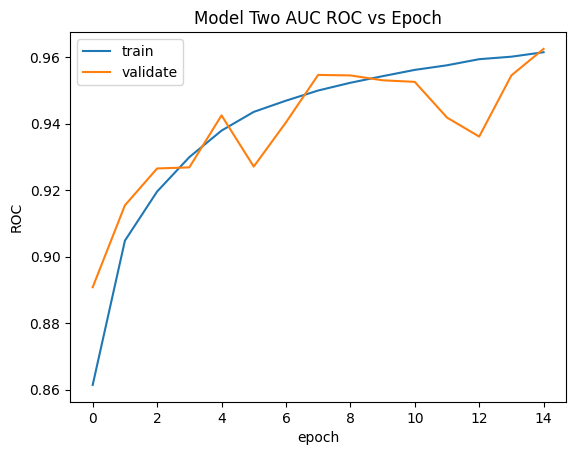

In [13]:
plt.plot(history_model2.history['accuracy'])
plt.plot(history_model2.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(history_model2.history['loss'])
plt.plot(history_model2.history['val_loss'])
plt.title('Model 2 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(history_model2.history['auc'])
plt.plot(history_model2.history['val_auc'])
plt.title('Model Two AUC ROC vs Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

In [14]:
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_data_new,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [15]:
predictions = model2.predict(test_generator, verbose=1)

2023-04-01 11:20:01.946154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57458/57458 [==============================] - 76s 1ms/step


In [16]:
predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_data_new['id'].apply(lambda x: x.split('.')[0])
threshold = 0.5
binary_predictions = np.where(predictions < threshold, 0, 1)
submission_df['label'] = binary_predictions.tolist()
submission_df.head()

,id,label
0,53c4ded2d590681ca13d744c486c71d322a16057,0
1,8c30c2be587fff64599c6b6139c86dd24995c02c,0
2,50ddfc340d46b4e7056221450d35df1d77903e3f,1
3,b3c6fc1f0976632729f24647732a59c3e00b218a,0
4,a176eb24bbfc11549b78cd5dd49c0b852db0590c,1


0    37110
1    20348
Name: label, dtype: int64


([<matplotlib.patches.Wedge at 0x7fada008a910>,
 [Text(-0.4866096792188796, 0.9865145817931428, '0-Non-cancerous'),
  Text(0.48660967921887904, -0.986514581793143, '1-Cancerous')],
 [Text(-0.2654234613921161, 0.5380988627962596, '64.59%'),
  Text(0.2654234613921158, -0.5380988627962597, '35.41%')])

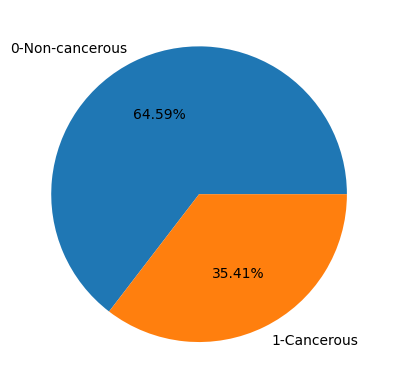

In [17]:
unique_counts = submission_df['label'].value_counts()
print(unique_counts)

plt.pie(unique_counts.tolist(), 
        labels = ['0-Non-cancerous','1-Cancerous'],
        autopct='%1.2f%%'
       )

In [24]:
submission_df['label'] = submission_df['label'].replace({0: 'no cancer', 1: 'cancer'})

# Display the updated submission_df
print(submission_df.head())

                                         id      label
0  53c4ded2d590681ca13d744c486c71d322a16057  no cancer
1  8c30c2be587fff64599c6b6139c86dd24995c02c  no cancer
2  50ddfc340d46b4e7056221450d35df1d77903e3f     cancer
3  b3c6fc1f0976632729f24647732a59c3e00b218a  no cancer
4  a176eb24bbfc11549b78cd5dd49c0b852db0590c     cancer


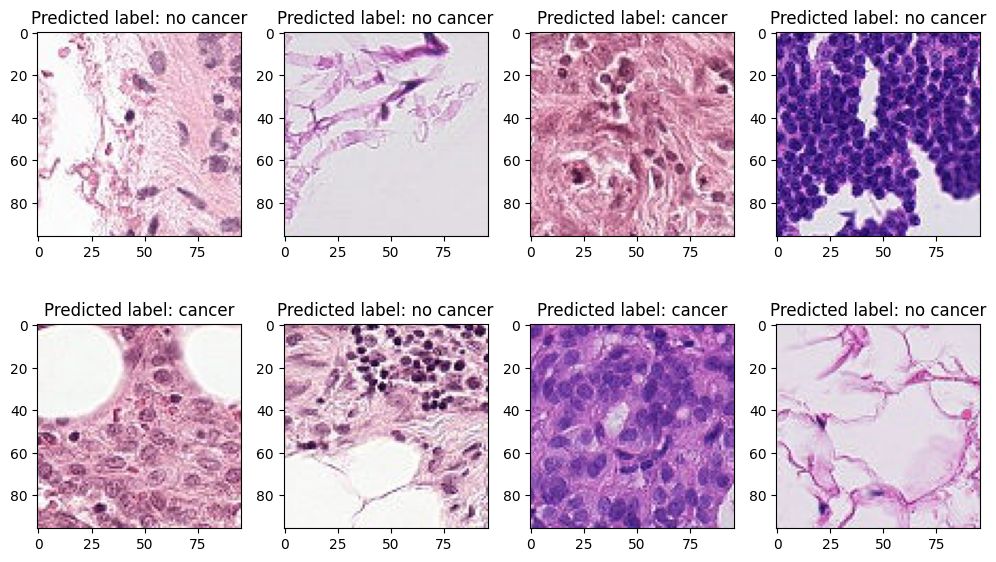

In [25]:
num_rows = 2
num_cols = 4

# Create a new figure with the specified size
fig = plt.figure(figsize=(10, 6))

# Loop through the rows and columns of the subplot grid
for i in range(num_rows):
    for j in range(num_cols):
        # Calculate the index of the current subplot
        index = i * num_cols + j
        
        # Load the image using the id from submission_df
        row = submission_df.iloc[index]
        img_id = row['id']
        img_path = './test/' + img_id + '.tif'  # replace with your image path
        img = Image.open(img_path)
        
        # Plot the image in the current subplot
        ax = fig.add_subplot(num_rows, num_cols, index + 1)
        ax.imshow(img)
        ax.set_title('Predicted label: {}'.format(row['label']))

# Adjust the spacing between the subplots and display the plot
plt.tight_layout()
plt.show()

    Its not a perfect model, but still an auucary of 85 is not bad either. We can try other parameters to see how it works
    or train a new model again